In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sympy as sy
from IPython.display import *   # to be able to use display
sy.init_printing(use_latex=True)   # pretty printing

import scipy.integrate as integrate

Consider the following BVP for $u=u(x)$:
\begin{align}
   u''(t) &= -\pi^2\sin(\pi t),  \quad t\in[0,1],\\
    u(0)&=0, \;\; u(1)=0. \quad 
\end{align}

In [2]:
# Define symbolic variables
t = sy.Symbol('t', real=True)
u = sy.Function('u') 

# Exact
exact = sy.sin(sy.pi*t)

#Data for the BVP
f = exact.diff(t,2)
a = 0
b = 1
alpha = exact.subs(t,a)
beta = exact.subs(t,b)

# Lambdify
exactfun = sy.lambdify([t], exact  , 'numpy')
ffun = sy.lambdify([t], f , 'numpy')

# Display data
display(sy.Eq(u(t),exact))
display(f)
display(alpha)
display(beta)

In [3]:
exact

In [4]:
n = 2 #number of points
h, mesh = 1./(n+1), np.linspace(0.0, 1.0, n+2)
mesh

array([0.        , 0.33333333, 0.66666667, 1.        ])

In [5]:
mesh[0]

# Colocation

In [6]:
def basis_poly(n=2):
    """
    Generate basis of polynomials of degree n+1, 
    This basis is: 1, t, ..., t^{n+1}  
    n+2 degrees of freedom - 2 boundary conditions = n interior points
    """
    basis_poly = [(1.*t**i).as_poly() for i in range(1, n+2)]
    def const_1(x):
        return 1
    basis_poly = [const_1]+basis_poly
    
    return basis_poly

In [7]:
def basis_sin(n=2, L = b-a):
    basis_sin = [sy.sin((k*sy.pi*t)/L) for k in range(1, n+2)]
    
    return basis_sin
                    
            

In [8]:
def colocation(basis=basis_poly, verbose = False):
    """
    Solve above BVP by colocation method using canonical polynomials basis.
    
    Return: Solution
    """
    
    n = len(basis) - 2  #Number of interior points
    
    mesh = np.linspace(0.0, 1.0, n+2)
    
#     #Basis functions
#     basis = [(1.*t**i).as_poly() for i in range(1, n+2)]
#     def const_1(x):
#         return 1
#     basis = [const_1]+basis
    
    # defining system matrix
    A = np.zeros((n+2, n+2))
    for i in range(n+2):
        A[0,i] = basis[i](mesh[0])
        A[n+1,i] = basis[i](mesh[n+1]) 
    for i in range(1,n+1):
        A[i,0] = 0
        for j in range(1,n+2):
            A[i,j] = basis[j].diff(t,t)(mesh[i])
            
    if verbose:
        print(f"System matrix A:\n {A}")

    #vector f(t_i)
    F = ffun(mesh)
    if verbose:
        print(f"System vector F:\n {F}")
    
    #coefficients for the solution
    u = np.linalg.solve(A,F)
    
    u_tilde = u[0]
    for i in range(1, n+2):
        u_tilde += u[i]*basis[i]
        
    return u_tilde

In [9]:
u_tilde = colocation(basis=basis_poly(2), verbose = True)
display(u_tilde)

System matrix A:
 [[1. 0. 0. 0.]
 [0. 0. 2. 2.]
 [0. 0. 2. 4.]
 [1. 1. 1. 1.]]
System vector F:
 [-0.00000000e+00 -8.54732814e+00 -8.54732814e+00 -1.20867794e-15]


## Plot approximantions

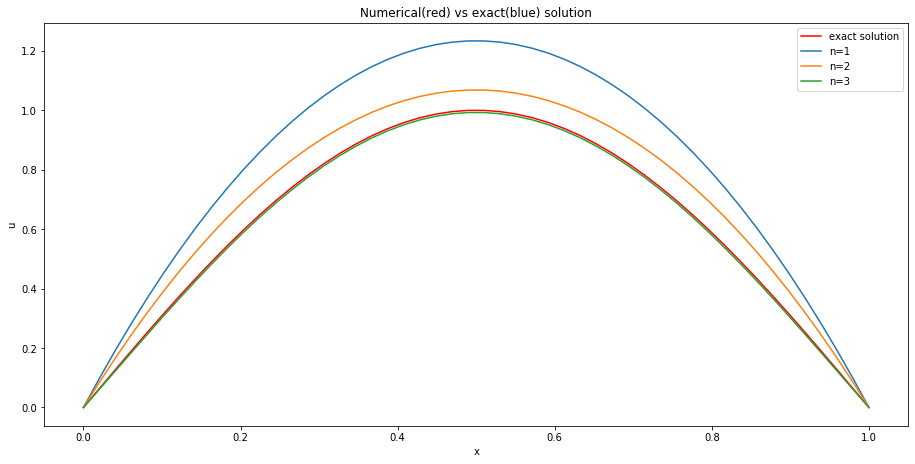

In [10]:
# Exact solution
x_fine = np.linspace(0., 1., 50)
exact_array = exactfun(x_fine)

# Plot
fig = plt.figure(figsize=(15, 7))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
plt.plot(x_fine, exact_array, 'red', label="exact solution")

for n in [1,2,3]:
    basis_ = basis_poly(n)
    u_tilde = colocation(basis_)
    numerical_array = np.array([u_tilde(x) for x in x_fine])
    plt.plot(x_fine, numerical_array, label=f'n={n}')

axes.set_xlabel('x')
axes.set_ylabel('u')
plt.legend()
axes.set_title('Numerical(red) vs exact(blue) solution');

# Galerkin

In [11]:
def galerkin(n=1, verbose=False):
    """
    Solve above BVP by colocation method using evenly spaced mehs and Legebdre basis of linear polynomials.
    
    Return: vector of solution coefficients, mesh, 
    """
    
    h, mesh = 1./(n+1), np.linspace(0.0, 1.0, n+2)

    # Stifness matrix K
    K = 2.*np.eye(n+2, k=0) - np.eye(n+2, k=1) - np.eye(n+2, k=-1)
    #Add oundary conditions
    K[0,0], K[0,1] = 1, 0
    K[-1,-1], K[-1,-2] = 1, 0
    #divide by stpe h
    K /= h
    
    #System vector
    F = np.zeros(n+2)
    for i in range(1,n+1):
        integrand_1 = lambda p: -ffun(p)*(p-mesh[i-1])
        integrand_2 = lambda p: -ffun(p)*(mesh[i+1]-p)
        F[i] = integrate.quad(integrand_1, mesh[i-1],mesh[i])[0] + integrate.quad(integrand_2, mesh[i],mesh[i+1])[0]
        F[i] /= h
    F[0] = alpha/h
    F[-1] = beta/h
    
    if verbose:
        print(f"System matrix K:\n {K}")
        print(f"System vectr F:\n {F}")
        
    # Solution
    u = np.linalg.solve(K,F)
    
    return u, mesh
    

In [12]:
# Solution
u, mesh = galerkin(1, verbose=True)
u

System matrix K:
 [[ 2.  0.  0.]
 [-2.  4. -2.]
 [ 0.  0.  2.]]
System vectr F:
 [0. 4. 0.]


array([0., 1., 0.])

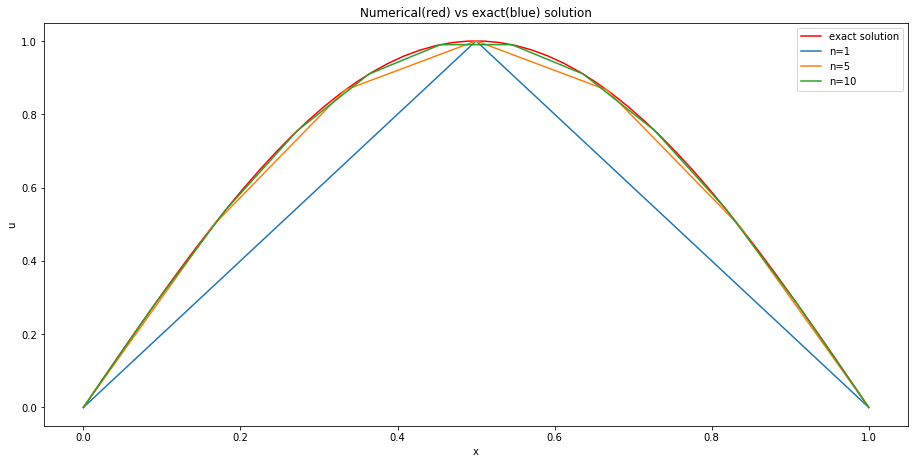

In [13]:
# Exact solution
x_fine = np.linspace(0., 1., 50)
exact_array = exactfun(x_fine)

# Plot
fig = plt.figure(figsize=(15, 7))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
plt.plot(x_fine, exact_array, 'red', label="exact solution")

for n in [1,5, 10]:
    u, mesh = galerkin(n)
    plt.plot(mesh, u, label=f'n={n}')

axes.set_xlabel('x')
axes.set_ylabel('u')
plt.legend()
axes.set_title('Numerical(red) vs exact(blue) solution');

# Rayleigh-Ritz

In [14]:
def least_squares(n):
    
    #System matrix
    A = np.zeros((n-1, n-1))
    for i in range(n-1):
        for j in range(n-1):
            A[i,j] = (i+2)*(j+2)*(i+1)*(j+1)/(i+j+1)
            
    #System vector
    F = np.zeros(n-1)
    for i in range(n-1):
        #print(i)
        integrand = lambda p: ffun(p)*p**i
        F[i] = (i+2)*(i+1)*integrate.quad(integrand, 0,1)[0]
        #print(F[i])
        
    # Solution vector
    u = np.linalg.solve(A,F)
    
    
    basis = [(t**(i+2)-t).as_poly() for i in range(n-1)]
    
    #Solution function
    u_tilde = 0
    for i in range(n-1):
        u_tilde += u[i]*basis[i]
        
    return u_tilde

In [15]:
u_tilde = least_squares(2)
[u_tilde(x) for x in x_fine]

In [16]:
least_squares(5)

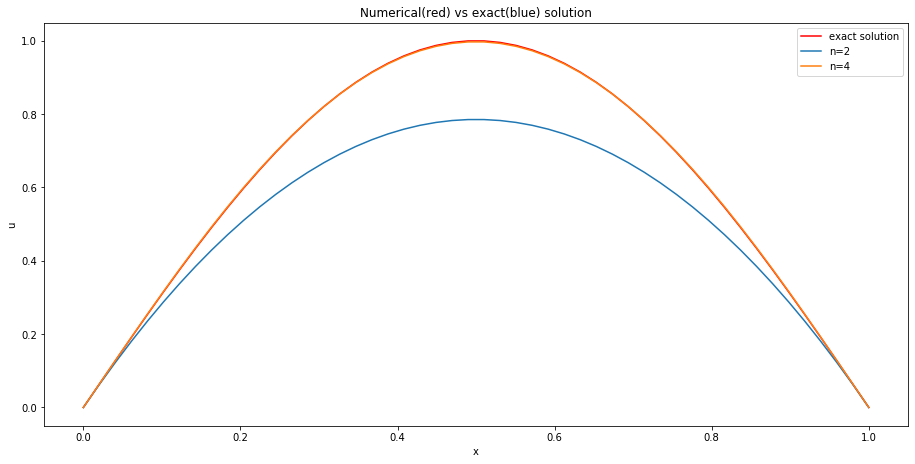

In [17]:
# Exact solution
x_fine = np.linspace(0., 1., 50)
exact_array = exactfun(x_fine)


# Plot
fig = plt.figure(figsize=(15, 7))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)
plt.plot(x_fine, exact_array, 'red', label="exact solution")

for n in [2, 4]:
    u_tilde = least_squares(n)
    numerical_array = np.array([u_tilde(x) for x in x_fine])
    plt.plot(x_fine, numerical_array, label=f'n={n}')

axes.set_xlabel('x')
axes.set_ylabel('u')
plt.legend()
axes.set_title('Numerical(red) vs exact(blue) solution');